# Inference 
En este notebook se implementan los procedimientos de inferencia estadística:
- Intervalos de confianza para media y volatilidad
- Tests t (una muestra, dos muestras, Welch)
- Pruebas de varianzas (Levene / F)
- Alternativas no paramétricas
- Bootstrap
- Correcciones por comparaciones múltiples
- Regresión CAPM con diagnóstico y errores robustos
- Análisis de potencia


In [1]:
"""
Configuración inicial del entorno y carga de datos.

Esta celda define:
- dependencias del proyecto
- parámetros de reproducibilidad
- rutas del proyecto de forma robusta
- validaciones mínimas de existencia de datos
- carga de los datasets principales
"""

# ==============================
# Librerías estándar
# ==============================
import os
import json
import logging
import warnings
from pathlib import Path

# ==============================
# Librerías científicas y de visualización
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import yfinance as yf

# ==============================
# Estadística e inferencia
# ==============================
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.api import DescrStatsW, CompareMeans
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower, TTestPower
from statsmodels.stats.diagnostic import (
    het_breuschpagan,
    acorr_ljungbox,
    acorr_breusch_godfrey,
    lilliefors
)
from statsmodels.stats.stattools import durbin_watson, jarque_bera

# ==============================
# Análisis multivariante
# ==============================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ==============================
# Utilidades de Jupyter
# ==============================
from IPython.display import display, Markdown

# ------------------------------------------------------------------
# Configuración global
# ------------------------------------------------------------------

# Semilla fija para garantizar reproducibilidad de resultados
np.random.seed(42)

# Estilo gráfico consistente para todas las visualizaciones
sns.set(style="whitegrid")

# Silenciar warnings no críticos para mejorar legibilidad del output
warnings.filterwarnings("ignore")

# Configuración básica de logging informativo
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# ------------------------------------------------------------------
# Definición de rutas del proyecto
# ------------------------------------------------------------------

# Directorio del notebook en ejecución
NOTEBOOK_DIR = Path.cwd()

# Raíz del proyecto (un nivel por encima del notebook)
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Directorio de datos procesados
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# Archivos de entrada principales
PANEL_FILE = PROCESSED_DIR / "tech30_panel_monthly_2018_2024.csv"
AGG_FILE   = PROCESSED_DIR / "tech30_aggregated_stats_2018_2024.csv"

# ------------------------------------------------------------------
# Validación de existencia de datos
# ------------------------------------------------------------------

missing_files = [str(p) for p in (PANEL_FILE, AGG_FILE) if not p.exists()]
if missing_files:
    raise FileNotFoundError(
        "No se encontraron los siguientes archivos:\n  - "
        + "\n  - ".join(missing_files)
        + f"\n\nDirectorio de trabajo actual: {NOTEBOOK_DIR}\n"
          "Verifique que la estructura 'data/processed' exista en la raíz del proyecto."
    )

# ------------------------------------------------------------------
# Carga de datos
# ------------------------------------------------------------------

# Panel mensual por empresa (2018–2024)
panel_df = pd.read_csv(PANEL_FILE, parse_dates=["Date"])

# Estadísticas agregadas por empresa
agg_df = pd.read_csv(AGG_FILE)

logging.info(f"Datos cargados correctamente: panel_df {panel_df.shape}, agg_df {agg_df.shape}")


INFO: Datos cargados correctamente: panel_df (2403, 6), agg_df (30, 7)


Antes de aplicar pruebas formales:
- verificamos distribución de retornos por empresa (normalidad)
- revisamos tamaño muestral T (~n meses por empresa)
- revisamos si usar pruebas paramétricas o no paramétricas


In [2]:
"""
Funciones utilitarias para inferencia estadística.

Esta celda contiene implementaciones explícitas de:
- intervalos de confianza paramétricos y no paramétricos
- tests de hipótesis clásicos y no paramétricos
- pruebas de permutación
- correcciones por comparaciones múltiples

Las funciones están diseñadas para trabajar con pandas.Series o array-like,
descartando valores faltantes cuando corresponda.
"""

def ci_mean_t(x, alpha=0.05):
    """
    Intervalo de confianza para la media usando la t de Student.

    Supone observaciones independientes y aproximadamente normales.
    Requiere al menos dos observaciones.

    Parameters
    ----------
    x : array-like o pandas.Series
        Muestra de datos (los NaN se eliminan).
    alpha : float
        Nivel de significancia (por defecto 0.05 → IC del 95%).

    Returns
    -------
    mean : float
        Media muestral.
    se : float
        Error estándar de la media.
    df : int
        Grados de libertad.
    (ci_low, ci_high) : tuple
        Límites inferior y superior del intervalo de confianza.
    """
    x = np.asarray(x.dropna()) if hasattr(x, "dropna") else np.asarray(x)
    n = len(x)
    if n < 2:
        raise ValueError("ci_mean_t: se requieren al menos 2 observaciones")
    mean = np.mean(x)
    s = np.std(x, ddof=1)
    se = s / np.sqrt(n)
    df = n - 1
    tval = stats.t.ppf(1 - alpha / 2, df)
    ci_low = mean - tval * se
    ci_high = mean + tval * se
    return mean, se, df, (ci_low, ci_high)


def bootstrap_ci_mean(x, n_boot=5000, alpha=0.05, random_state=None, return_boots=False):
    """
    Intervalo de confianza para la media mediante bootstrap percentil.

    No asume normalidad de la distribución y es útil en muestras pequeñas
    o distribuciones asimétricas.

    Parameters
    ----------
    x : array-like o pandas.Series
        Muestra de datos (los NaN se eliminan).
    n_boot : int
        Número de remuestreos bootstrap.
    alpha : float
        Nivel de significancia.
    random_state : int o None
        Semilla para reproducibilidad.
    return_boots : bool
        Si True, devuelve también la distribución bootstrap.

    Returns
    -------
    mean : float
        Media muestral.
    (ci_low, ci_high) : tuple
        Intervalo de confianza bootstrap.
    boots : ndarray, opcional
        Distribución bootstrap de la media.
    """
    rng = np.random.default_rng(random_state)
    x = np.asarray(x.dropna()) if hasattr(x, "dropna") else np.asarray(x)
    n = len(x)
    if n < 1:
        raise ValueError("bootstrap_ci_mean: serie vacía")
    boots = np.empty(n_boot)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        boots[i] = sample.mean()
    lower = np.percentile(boots, 100 * (alpha / 2))
    upper = np.percentile(boots, 100 * (1 - alpha / 2))
    if return_boots:
        return np.mean(x), (lower, upper), boots
    return np.mean(x), (lower, upper)


def one_sample_ttest(x, mu0=0.0, alternative='two-sided'):
    """
    Test t de una muestra para la hipótesis H0: mean = mu0.

    Permite alternativas bilaterales y unilaterales. El p-valor se ajusta
    manualmente a partir del p-valor bilateral de scipy.

    Parameters
    ----------
    x : array-like o pandas.Series
        Muestra de datos (los NaN se eliminan).
    mu0 : float
        Valor de la media bajo la hipótesis nula.
    alternative : {'two-sided', 'larger', 'smaller'}
        Tipo de hipótesis alternativa.

    Returns
    -------
    tstat : float
        Estadístico t.
    pvalue : float
        p-valor asociado.
    """
    x = np.asarray(x.dropna()) if hasattr(x, "dropna") else np.asarray(x)
    if len(x) < 2:
        raise ValueError("one_sample_ttest: se requieren al menos 2 observaciones")
    res = stats.ttest_1samp(x, popmean=mu0)
    tstat, p_two = res.statistic, res.pvalue
    if alternative == 'two-sided':
        return tstat, p_two
    if alternative == 'larger':
        if tstat > 0:
            p = p_two / 2
        else:
            p = 1 - p_two / 2
    elif alternative == 'smaller':
        if tstat < 0:
            p = p_two / 2
        else:
            p = 1 - p_two / 2
    else:
        raise ValueError("alternative debe ser 'two-sided', 'larger' o 'smaller'")
    return tstat, p


def welch_ttest(x1, x2, alternative='two-sided'):
    """
    Test t de Welch para dos muestras independientes con varianzas desiguales.

    Parameters
    ----------
    x1, x2 : array-like o pandas.Series
        Muestras independientes (los NaN se eliminan).
    alternative : {'two-sided', 'larger', 'smaller'}
        Tipo de hipótesis alternativa.

    Returns
    -------
    tstat : float
        Estadístico t.
    pvalue : float
        p-valor asociado.
    """
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    if len(x1) < 1 or len(x2) < 1:
        raise ValueError("welch_ttest: ambas muestras deben tener al menos 1 observación")
    res = stats.ttest_ind(x1, x2, equal_var=False)
    tstat, p_two = res.statistic, res.pvalue
    if alternative == 'two-sided':
        return tstat, p_two
    if alternative == 'larger':
        if tstat > 0:
            p = p_two / 2
        else:
            p = 1 - p_two / 2
    elif alternative == 'smaller':
        if tstat < 0:
            p = p_two / 2
        else:
            p = 1 - p_two / 2
    else:
        raise ValueError("alternative debe ser 'two-sided', 'larger' o 'smaller'")
    return tstat, p


def levene_test(x1, x2, center='median'):
    """
    Test de Levene para evaluar igualdad de varianzas entre dos muestras.

    Parameters
    ----------
    x1, x2 : array-like o pandas.Series
        Muestras independientes.
    center : {'median', 'mean'}
        Medida de centralidad usada en el test (mediana es más robusta).

    Returns
    -------
    statistic, pvalue : floats
        Resultado del test de Levene.
    """
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    if len(x1) < 2 or len(x2) < 2:
        raise ValueError("levenes_test: ambas muestras deben tener al menos 2 observaciones")
    return stats.levene(x1, x2, center=center)


def mannwhitney_test(x1, x2):
    """
    Test no paramétrico de Mann–Whitney U para dos muestras independientes.

    Útil cuando no se cumple el supuesto de normalidad.

    Parameters
    ----------
    x1, x2 : array-like o pandas.Series
        Muestras independientes.

    Returns
    -------
    statistic, pvalue : floats
        Resultado del test Mann–Whitney U.
    """
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    if len(x1) < 1 or len(x2) < 1:
        raise ValueError("mannwhitney_test: muestras vacías")
    return stats.mannwhitneyu(x1, x2, alternative='two-sided')


def permutation_test_diff_means(x1, x2, n_perm=5000, random_state=None, return_null_dist=False):
    """
    Test de permutación para la diferencia de medias (dos colas).

    No depende de supuestos paramétricos y aproxima la distribución nula
    mediante re-etiquetado aleatorio de las observaciones.

    Parameters
    ----------
    x1, x2 : array-like o pandas.Series
        Muestras independientes.
    n_perm : int
        Número de permutaciones.
    random_state : int o None
        Semilla para reproducibilidad.
    return_null_dist : bool
        Si True, devuelve la distribución nula generada.

    Returns
    -------
    obs_diff : float
        Diferencia observada de medias.
    pvalue : float
        p-valor empírico.
    perm_diffs : ndarray, opcional
        Distribución nula de diferencias de medias.
    """
    rng = np.random.default_rng(random_state)
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    n1 = len(x1); n2 = len(x2)
    if n1 < 1 or n2 < 1:
        raise ValueError("permutation_test_diff_means: muestras vacías")
    obs_diff = np.mean(x1) - np.mean(x2)
    pooled = np.concatenate([x1, x2])
    perm_diffs = np.empty(n_perm)
    for i in range(n_perm):
        perm = rng.permutation(pooled)
        perm_diffs[i] = perm[:n1].mean() - perm[n1:].mean()
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
    if return_null_dist:
        return obs_diff, p_value, perm_diffs
    return obs_diff, p_value


def apply_multiple_corrections(pvals, alpha=0.05, method='fdr_bh'):
    """
    Corrección por comparaciones múltiples usando multipletests.

    Parameters
    ----------
    pvals : array-like
        p-valores originales.
    alpha : float
        Nivel de significancia global.
    method : str
        Método de corrección (e.g. 'bonferroni', 'fdr_bh').

    Returns
    -------
    reject : ndarray (bool)
        Indicador de hipótesis rechazadas.
    pvals_corrected : ndarray
        p-valores ajustados.
    """
    pvals = np.asarray(pvals)
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method=method)
    return reject, pvals_corrected


def pearson_r_ci(r, n, alpha=0.05):
    """
    Intervalo de confianza para el coeficiente de correlación de Pearson
    usando la transformación z de Fisher.

    Parameters
    ----------
    r : float
        Correlación muestral.
    n : int
        Tamaño muestral.
    alpha : float
        Nivel de significancia.

    Returns
    -------
    r : float
        Correlación original.
    (ci_low, ci_high) : tuple
        Intervalo de confianza para r.
    """
    if n <= 3:
        raise ValueError("pearson_r_ci: se requieren n>3")
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    lo, hi = z - z_crit * se, z + z_crit * se
    return r, (np.tanh(lo), np.tanh(hi))


Procedimiento:
- Para cada empresa: Shapiro-Wilk (o Lilliefors) sobre retornos (si n pequeño usar Shapiro)
- Si la mayoría viola normalidad (p < 0.05), preferir pruebas no paramétricas o bootstrap
- Guardaremos un resumen con n, p_shapiro, decisión


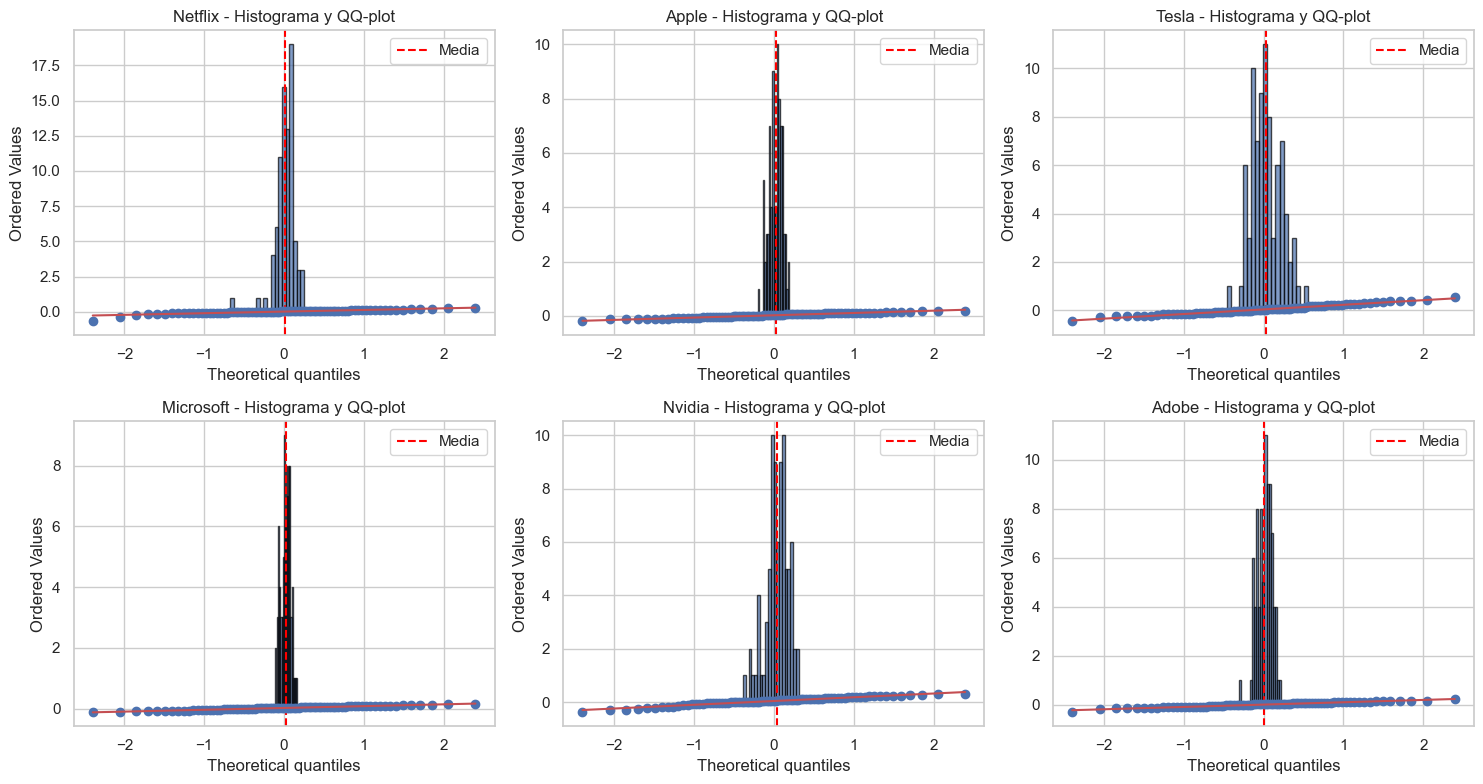

In [3]:
def normality_summary(panel_df, alpha=0.05, correction_method='fdr_bh'):
    """
    Evalúa la normalidad de la variable 'Return' para cada empresa del panel de datos.

    Metodología:
    - Para cada empresa se extraen los retornos no nulos.
    - Si el tamaño muestral lo permite, se aplica el test de Shapiro-Wilk.
    - Si el test de Shapiro falla por razones numéricas, se utiliza Lilliefors
      (adaptación del test de Kolmogorov–Smirnov para normalidad).
    - Los p-values obtenidos se ajustan por comparaciones múltiples mediante
      el método especificado (por defecto FDR de Benjamini–Hochberg).

    Parámetros
    ----------
    panel_df : pd.DataFrame
        DataFrame en formato panel que contiene al menos las columnas
        'Company' y 'Return'.
    alpha : float, opcional
        Nivel de significancia estadística para los tests (por defecto 0.05).
    correction_method : str, opcional
        Método de corrección por comparaciones múltiples compatible con
        statsmodels.multipletests (por defecto 'fdr_bh').

    Retorna
    -------
    pd.DataFrame
        Tabla resumen con las columnas:
        - Company: nombre de la empresa
        - n: número de observaciones utilizadas
        - test: test de normalidad aplicado
        - statistic: estadístico del test
        - p_value: p-value sin corregir
        - p_value_fdr: p-value corregido por múltiples tests
        - normal_reject_fdr: indicador booleano de rechazo de normalidad
    """
    rows = []

    # Iteración ordenada por empresa para asegurar reproducibilidad
    companies = sorted(panel_df['Company'].unique())

    for company in companies:
        returns = panel_df.loc[
            panel_df['Company'] == company, 'Return'
        ].dropna()

        n = len(returns)

        # Si no hay suficientes observaciones, no se realiza el test
        if n < 3:
            stat = np.nan
            pval = np.nan
            test_name = None
        else:
            try:
                # Test de Shapiro-Wilk para normalidad
                stat, pval = stats.shapiro(returns)
                test_name = 'Shapiro'
            except Exception:
                # Fallback a Lilliefors si Shapiro falla
                stat, pval = lilliefors(returns)
                test_name = 'Lilliefors'

        rows.append({
            'Company': company,
            'n': n,
            'test': test_name,
            'statistic': stat,
            'p_value': pval
        })

    df = pd.DataFrame(rows)

    # Corrección por comparaciones múltiples (solo sobre p-values válidos)
    valid_mask = df['p_value'].notna()

    if valid_mask.any():
        reject, pvals_corr, _, _ = multipletests(
            df.loc[valid_mask, 'p_value'].values,
            alpha=alpha,
            method=correction_method
        )
        df.loc[valid_mask, 'p_value_fdr'] = pvals_corr
        df.loc[valid_mask, 'normal_reject_fdr'] = reject.astype(bool)
    else:
        df['p_value_fdr'] = np.nan
        df['normal_reject_fdr'] = False

    # Ordenación para facilitar la inspección de los casos más críticos
    df = df.sort_values(
        by=['p_value_fdr', 'p_value'],
        na_position='last'
    ).reset_index(drop=True)

    return df


# Ejecución del análisis de normalidad
norm_summary = normality_summary(
    panel_df,
    alpha=0.05,
    correction_method='fdr_bh'
)

norm_summary.head(10)


# Diagnóstico visual para un subconjunto representativo de empresas
companies_sample = ['Netflix', 'Apple', 'Tesla', 'Microsoft', 'Nvidia', 'Adobe']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, company in zip(axes.flat, companies_sample):
    returns = panel_df.loc[
        panel_df['Company'] == company, 'Return'
    ].dropna()

    # Histograma de retornos
    ax.hist(returns, bins=20, edgecolor='black', alpha=0.7)

    # Línea vertical de la media muestral
    ax.axvline(
        returns.mean(),
        color='red',
        linestyle='--',
        label='Media'
    )

    # QQ-plot frente a la distribución normal
    stats.probplot(returns, dist="norm", plot=ax)

    ax.set_title(f'{company} - Histograma y QQ-plot')
    ax.legend()

plt.tight_layout()

# Guardado del diagnóstico gráfico para documentación del análisis
plt.savefig(
    os.path.join(PROCESSED_DIR, 'normality_diagnostic.png'),
    dpi=300
)

plt.show()


Calculamos:
- IC t (clásico) para la media de retornos por empresa
- IC bootstrap (percentil) para robustez
Guardamos una tabla con mean, se, df, ci_t_low, ci_t_high, ci_boot_low, ci_boot_high



### Interpretación Económica – One-Sample t-tests

Se resumen a continuación los retornos medios mensuales junto con sus
intervalos de confianza al 95% (paramétricos y bootstrap).

| Empresa | Media mensual | IC 95% t-test | IC 95% Bootstrap | Relevancia económica |
|---------|---------------|---------------|------------------|---------------------|
| Palantir | 0.041 | [-0.029, 0.111] | [-0.024, 0.115] | Sí |
| Nvidia | 0.038 | [0.007, 0.068] | [0.006, 0.068] | Sí |
| Tesla | 0.035 | [-0.007, 0.076] | [-0.003, 0.076] | Sí |
| Broadcom | 0.030 | [0.010, 0.050] | [0.010, 0.050] | Sí |
| Fortinet | 0.028 | [0.004, 0.052] | [0.004, 0.051] | Sí |
| Cloudflare | 0.028 | [-0.018, 0.074] | [-0.018, 0.072] | Sí |
| ServiceNow | 0.024 | [0.006, 0.041] | [0.007, 0.041] | Sí |
| Apple | 0.022 | [0.004, 0.041] | [0.004, 0.040] | Sí |
| Taiwan Semiconductor | 0.020 | [-0.000, 0.041] | [0.001, 0.041] | Sí |
| Microsoft | 0.019 | [0.006, 0.032] | [0.006, 0.032] | Sí |
| ASML | 0.016 | [-0.005, 0.037] | [-0.005, 0.037] | Sí |
| Oracle | 0.015 | [-0.002, 0.032] | [-0.001, 0.033] | Sí |
| Netflix | 0.014 | [-0.013, 0.042] | [-0.014, 0.040] | Sí |
| Alphabet | 0.014 | [-0.002, 0.030] | [-0.002, 0.029] | Sí |
| Meta Platforms | 0.014 | [-0.011, 0.039] | [-0.011, 0.037] | Sí |
| Amazon | 0.013 | [-0.006, 0.033] | [-0.005, 0.032] | Sí |
| Infosys | 0.013 | [-0.004, 0.030] | [-0.004, 0.030] | Sí |
| Salesforce | 0.013 | [-0.008, 0.034] | [-0.007, 0.033] | Sí |
| Spotify | 0.013 | [-0.017, 0.043] | [-0.016, 0.042] | Sí |
| SAP | 0.011 | [-0.008, 0.030] | [-0.008, 0.029] | Sí |
| Accenture | 0.011 | [-0.005, 0.026] | [-0.005, 0.026] | Sí |
| Sony | 0.010 | [-0.007, 0.028] | [-0.007, 0.027] | Sí |
| Adobe | 0.010 | [-0.011, 0.030] | [-0.011, 0.030] | No |
| Workday | 0.009 | [-0.013, 0.032] | [-0.013, 0.031] | No |
| IBM | 0.008 | [-0.008, 0.024] | [-0.008, 0.023] | No |
| Cisco | 0.007 | [-0.009, 0.022] | [-0.008, 0.022] | No |
| Samsung | 0.003 | [-0.013, 0.019] | [-0.013, 0.019] | No |
| Tencent | 0.000 | [-0.022, 0.022] | [-0.023, 0.022] | No |
| Intel | -0.009 | [-0.031, 0.014] | [-0.031, 0.013] | No |
| Snowflake | -0.009 | [-0.046, 0.027] | [-0.043, 0.028] | No |


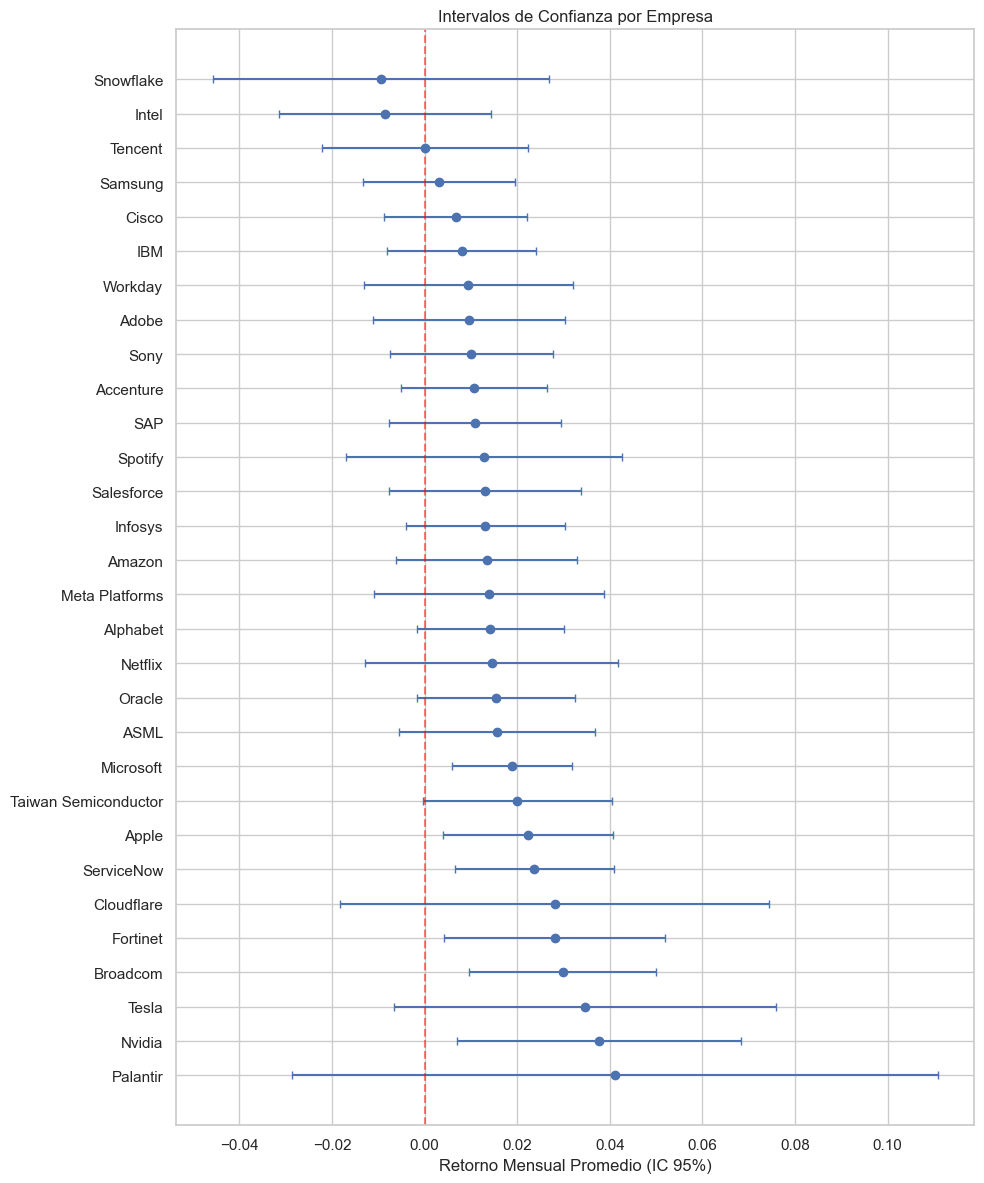

In [4]:
"""
Cálculo de intervalos y pruebas por empresa (inferencia univariada).

Salida:
- ci_df: DataFrame con estadísticas por empresa:
  ['Company','n','MeanReturn','SE','df','CI_t_low','CI_t_high',
   'CI_boot_low','CI_boot_high','BootMean','t_stat','p_t','p_boot',
   'IncludesZero_t','IncludesZero_boot','cohens_d', ... ajustes FDR ...]

Notas metodológicas:
- IC t: intervalo clásico basado en t de Student (requiere n>=2).
- IC bootstrap: percentil bootstrap de la media (n_boot=3000, seed=42).
- p_boot: p-valor empírico obtenido remuestreando la muestra centrada (impone H0).
- Correcciones por comparaciones múltiples (FDR) se aplican por separado
  a p_t (t-test) y p_boot (bootstrap).
"""

results = []

# Iteración ordenada por empresa para reproducibilidad y consistencia
companies = sorted(panel_df['Company'].unique())

for company in companies:
    x = panel_df.loc[
        panel_df['Company'] == company, 'Return'
    ].dropna().values

    n = len(x)
    if n < 2:
        # No hay suficientes datos para estimar ICs o realizar tests
        continue

    # Inicialización explícita de variables de salida
    mean = np.nan
    se = np.nan
    df = np.nan
    ci_t_low = np.nan
    ci_t_high = np.nan
    ci_boot_low = np.nan
    ci_boot_high = np.nan
    boots = None
    t_stat = np.nan
    p_t = np.nan
    p_boot = np.nan
    cohens_d = np.nan

    # ------------------------------------------------------------------
    # 1) Intervalo de confianza clásico (t de Student)
    # ------------------------------------------------------------------
    try:
        mean, se, df, (ci_t_low, ci_t_high) = ci_mean_t(
            x, alpha=0.05
        )
    except Exception:
        # Fallback numérico si la función de IC falla por cualquier razón
        mean = float(np.mean(x))
        se = float(np.std(x, ddof=1) / np.sqrt(max(1, n)))
        df = n - 1
        ci_t_low, ci_t_high = (np.nan, np.nan)

    # ------------------------------------------------------------------
    # 2) Intervalo de confianza bootstrap (percentil)
    # ------------------------------------------------------------------
    try:
        mean_b, (ci_boot_low, ci_boot_high), boots = bootstrap_ci_mean(
            x,
            n_boot=3000,
            random_state=42,
            return_boots=True
        )
    except Exception:
        boots = None

    # ------------------------------------------------------------------
    # 3) One-sample t-test (H0: media = 0)
    # ------------------------------------------------------------------
    try:
        t_stat, p_t = one_sample_ttest(
            x,
            mu0=0.0,
            alternative='two-sided'
        )
    except Exception:
        # Compatibilidad con scipy si el wrapper falla
        tt = stats.ttest_1samp(x, popmean=0.0)
        t_stat = float(tt.statistic)
        p_t = float(tt.pvalue)

    # ------------------------------------------------------------------
    # 4) p-value bootstrap bajo H0 (media = 0)
    #    Se construye la distribución nula centrando la muestra.
    # ------------------------------------------------------------------
    try:
        rng = np.random.default_rng(42)

        # Centrar la muestra para imponer H0 (media cero)
        x_centered = x - mean
        n_boot = 3000
        boots_null = np.empty(n_boot)

        for i in range(n_boot):
            sample = rng.choice(
                x_centered,
                size=n,
                replace=True
            )
            boots_null[i] = sample.mean()

        # p-valor bilateral empírico: proporción de |difs| >= |obs_mean|
        p_boot = float(
            np.mean(np.abs(boots_null) >= np.abs(mean))
        )
    except Exception:
        p_boot = np.nan

    # ------------------------------------------------------------------
    # 5) Tamaño del efecto (Cohen's d, una muestra)
    # ------------------------------------------------------------------
    sd = np.std(x, ddof=1)
    cohens_d = float(mean / sd) if sd > 0 else np.nan

    # ------------------------------------------------------------------
    # 6) Inclusión del cero en los intervalos (flags)
    # ------------------------------------------------------------------
    includes_zero_t = (
        ci_t_low <= 0 <= ci_t_high
        if not np.isnan(ci_t_low) and not np.isnan(ci_t_high)
        else np.nan
    )

    includes_zero_boot = (
        ci_boot_low <= 0 <= ci_boot_high
        if not np.isnan(ci_boot_low) and not np.isnan(ci_boot_high)
        else np.nan
    )

    results.append({
        'Company': company,
        'n': n,
        'MeanReturn': mean,
        'SE': se,
        'df': df,
        'CI_t_low': ci_t_low,
        'CI_t_high': ci_t_high,
        'CI_boot_low': ci_boot_low,
        'CI_boot_high': ci_boot_high,
        'BootMean': float(mean_b) if 'mean_b' in locals() else np.nan,
        't_stat': t_stat,
        'p_t': p_t,
        'p_boot': p_boot,
        'IncludesZero_t': includes_zero_t,
        'IncludesZero_boot': includes_zero_boot,
        'cohens_d': cohens_d
    })

# Construcción del DataFrame final y ordenación por retorno medio
ci_df = (
    pd.DataFrame(results)
      .sort_values('MeanReturn', ascending=False)
      .reset_index(drop=True)
)

# ------------------------------------------------------------------
# Corrección por comparaciones múltiples (FDR) – t-test
# ------------------------------------------------------------------
mask_t = ci_df['p_t'].notna()
if mask_t.any():
    rej_t, pvals_t_corr, _, _ = multipletests(
        ci_df.loc[mask_t, 'p_t'].values,
        alpha=0.05,
        method='fdr_bh'
    )
    ci_df.loc[mask_t, 'p_t_fdr'] = pvals_t_corr
    ci_df.loc[mask_t, 'signif_t_fdr'] = rej_t.astype(bool)
else:
    ci_df['p_t_fdr'] = np.nan
    ci_df['signif_t_fdr'] = False

# ------------------------------------------------------------------
# Corrección por comparaciones múltiples (FDR) – bootstrap
# ------------------------------------------------------------------
mask_b = ci_df['p_boot'].notna()
if mask_b.any():
    rej_b, pvals_b_corr, _, _ = multipletests(
        ci_df.loc[mask_b, 'p_boot'].values,
        alpha=0.05,
        method='fdr_bh'
    )
    ci_df.loc[mask_b, 'p_boot_fdr'] = pvals_b_corr
    ci_df.loc[mask_b, 'signif_boot_fdr'] = rej_b.astype(bool)
else:
    ci_df['p_boot_fdr'] = np.nan
    ci_df['signif_boot_fdr'] = False

# Persistencia de resultados para trazabilidad del análisis
out_path = os.path.join(
    PROCESSED_DIR,
    'inference_mean_CI_by_company_enhanced.csv'
)
ci_df.to_csv(out_path, index=False)

# Mostrar una vista rápida del DataFrame resultante
ci_df.head()

# ------------------------------------------------------------------
# Interpretación económica: tabla en Markdown resumida
# ------------------------------------------------------------------
markdown_text = """
### Interpretación Económica – One-Sample t-tests

Se resumen a continuación los retornos medios mensuales junto con sus
intervalos de confianza al 95% (paramétricos y bootstrap).
"""

markdown_text += """
| Empresa | Media mensual | IC 95% t-test | IC 95% Bootstrap | Relevancia económica |
|---------|---------------|---------------|------------------|---------------------|
"""

for _, row in ci_df.iterrows():
    econ_sig = 'Sí' if row['MeanReturn'] > 0.01 else 'No'
    markdown_text += (
        f"| {row['Company']} | "
        f"{row['MeanReturn']:.3f} | "
        f"[{row['CI_t_low']:.3f}, {row['CI_t_high']:.3f}] | "
        f"[{row['CI_boot_low']:.3f}, {row['CI_boot_high']:.3f}] | "
        f"{econ_sig} |\n"
    )

display(Markdown(markdown_text))

# ------------------------------------------------------------------
# Forest plot de intervalos de confianza y guardado (PNG)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 12))

y_pos = np.arange(len(ci_df))

ax.errorbar(
    ci_df['MeanReturn'],
    y_pos,
    xerr=[
        ci_df['MeanReturn'] - ci_df['CI_t_low'],
        ci_df['CI_t_high'] - ci_df['MeanReturn']
    ],
    fmt='o',
    capsize=3
)

ax.axvline(0, color='red', linestyle='--', alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df['Company'])
ax.set_xlabel('Retorno Mensual Promedio (IC 95%)')
ax.set_title('Intervalos de Confianza por Empresa')

plt.tight_layout()
plt.savefig(
    os.path.join(PROCESSED_DIR, 'forestplot_ci.png'),
    dpi=300
)
plt.show()


Muchos trabajos en finanzas prueban si el retorno medio es significativamente distinto de cero.
Realizamos la prueba t de una muestra para cada empresa y guardamos p-values y estadístico.
Aplicaremos correcciones por comparaciones múltiples (Bonferroni y FDR).


In [5]:
"""
Resumen: One-sample t-test por empresa (H0: μ = 0).

Este bloque complementa la inferencia ya calculada en ci_df y produce:
- tt_df: DataFrame con estadísticos t, p-values y tamaño del efecto (Cohen's d)
- correcciones por comparaciones múltiples (Bonferroni y FDR)
- persistencia de resultados para trazabilidad
"""

tt_results = []

# Iteración ordenada por empresa para consistencia en salidas
for c in sorted(panel_df['Company'].unique()):
    # Extraer series de retornos no nulos
    r = panel_df.loc[panel_df['Company'] == c, 'Return'].dropna().values
    n = len(r)
    if n < 2:
        # No hay suficientes observaciones para realizar el test t
        continue

    mean = r.mean()
    sd = r.std(ddof=1)

    # Test t de una muestra (compatible con variantes de scipy)
    try:
        tstat, pval = one_sample_ttest(r, mu0=0.0, alternative='two-sided')
    except Exception:
        # Fallback a la implementación directa de scipy si falla la wrapper
        res = stats.ttest_1samp(r, popmean=0.0)
        tstat, pval = res.statistic, res.pvalue

    # Tamaño del efecto: Cohen's d para una muestra (mean / sd)
    cohens_d = mean / sd if sd > 0 else np.nan

    tt_results.append({
        'Company': c,
        'n': n,
        'mean': mean,
        'sd': sd,
        'tstat': tstat,
        'p_t': pval,
        'cohens_d': cohens_d
    })

# Construcción del DataFrame ordenado por p-valor para facilitar revisión
tt_df = (
    pd.DataFrame(tt_results)
      .sort_values('p_t')
      .reset_index(drop=True)
)

# -------------------------------------------------------
# Correcciones por comparaciones múltiples
# - Bonferroni: control estricto de tipo I
# - FDR (Benjamini–Hochberg): control de tasa de falsos descubrimientos
# -------------------------------------------------------

mask = tt_df['p_t'].notna()

if mask.any():
    # Aplicar Bonferroni y FDR sólo sobre p-values válidos
    rej_bonf, p_bonf, _, _ = multipletests(tt_df.loc[mask, 'p_t'], alpha=0.05, method='bonferroni')
    rej_fdr,  p_fdr,  _, _ = multipletests(tt_df.loc[mask, 'p_t'], alpha=0.05, method='fdr_bh')

    tt_df.loc[mask, 'p_bonf'] = p_bonf
    tt_df.loc[mask, 'reject_bonf'] = rej_bonf.astype(bool)
    tt_df.loc[mask, 'p_fdr'] = p_fdr
    tt_df.loc[mask, 'reject_fdr'] = rej_fdr.astype(bool)
else:
    # Mantener columnas con valores por defecto para consistencia
    tt_df['p_bonf'] = np.nan
    tt_df['reject_bonf'] = False
    tt_df['p_fdr'] = np.nan
    tt_df['reject_fdr'] = False

# Persistencia del resumen clásico para trazabilidad y reproducibilidad
out_path = os.path.join(PROCESSED_DIR, 'one_sample_ttest_results_classical.csv')
tt_df.to_csv(out_path, index=False)

# Vista rápida de los resultados principales
tt_df.head(10)


,Company,n,mean,sd,tstat,p_t,cohens_d,p_bonf,reject_bonf,p_fdr,reject_fdr
0,Broadcom,83,0.029832,0.092371,2.942288,0.004235,0.322958,0.127044,False,0.068911,False
1,Microsoft,83,0.018964,0.059285,2.914284,0.004594,0.319884,0.137822,False,0.068911,False
2,ServiceNow,83,0.023737,0.078987,2.737873,0.007582,0.300521,0.227466,False,0.075822,False
3,Nvidia,83,0.037576,0.140490,2.436684,0.016987,0.267461,0.509623,False,0.104925,False
4,Apple,83,0.022371,0.084030,2.425393,0.017488,0.266222,0.524625,False,0.104925,False
5,Fortinet,83,0.028135,0.109302,2.345041,0.021442,0.257402,0.643266,False,0.107211,False
6,Taiwan Semiconductor,83,0.020067,0.093745,1.950126,0.054578,0.214054,1.000000,False,0.233907,False
7,Oracle,83,0.015425,0.078020,1.801174,0.075352,0.197704,1.000000,False,0.262313,False
8,Alphabet,83,0.014190,0.072604,1.780526,0.078694,0.195438,1.000000,False,0.262313,False
9,Tesla,83,0.034602,0.189046,1.667516,0.099227,0.183034,1.000000,False,0.297680,False


- Si p < alpha (ajustado), rechazamos H0: μ = 0 y decimos que el retorno medio es significativamente distinto de 0.
- Reportar siempre: mean, t-stat, p, p ajustada, IC.
- En la discusión: comentar tamaño del efecto (mean) y su relevancia económica, no solo p-value.


Definimos grupos basados en Beta (del dataset agregado).  
Haremos: Levene (varianzas), Welch t-test (medias), Mann-Whitney (no paramétrica) y permutation test (robusto).


In [6]:
"""
Comparación de retornos mensuales por Beta (grupos 'low' vs 'high').

Flujo:
1. Definición de funciones auxiliares (Hedges' g, bootstrap para diferencia de medias).
2. Mapear beta desde agg_df a panel_df y etiquetar grupos.
3. Extraer retornos mensuales por grupo y calcular estadísticas descriptivas.
4. Aplicar tests estadísticos (Levene, Shapiro/Lilliefors, Welch, Mann–Whitney,
   permutation test, bootstrap) y calcular tamaño del efecto.
5. Guardar resumen y presentar interpretación en Markdown.

Notas:
- Se trabaja con retornos mensuales individuales (no con promedios agregados).
- Los p-values bootstrap y de permutación se calculan de forma empírica.
"""

# Funciones auxiliares (mantener la implementación original)
def hedges_g(x, y):
    """
    Hedges' g (corrige pequeño sesgo de d de Cohen).
    Retorna np.nan si alguna muestra es insuficiente.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx2 = x.var(ddof=1)
    sy2 = y.var(ddof=1)
    pooled_sd = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2))
    if pooled_sd == 0:
        return 0.0
    d = (x.mean() - y.mean()) / pooled_sd
    J = 1 - (3 / (4*(nx+ny) - 9))
    return d * J

def bootstrap_diff_mean_ci(x, y, n_boot=5000, alpha=0.05, random_state=42):
    """
    Bootstrap percentil para la diferencia de medias (x - y).
    Devuelve: (ci_lo, ci_hi), p_two_sided, boots (distribución bootstrap).
    """
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx < 1 or ny < 1:
        raise ValueError("bootstrap requires at least 1 obs per group")
    boots = np.empty(n_boot)
    for i in range(n_boot):
        sx = rng.choice(x, size=nx, replace=True)
        sy = rng.choice(y, size=ny, replace=True)
        boots[i] = sx.mean() - sy.mean()
    lo = np.percentile(boots, 100*(alpha/2))
    hi = np.percentile(boots, 100*(1-alpha/2))
    obs_diff = np.mean(x) - np.mean(y)
    p_two = float(np.mean(np.abs(boots) >= np.abs(obs_diff)))
    return (float(lo), float(hi)), p_two, boots

# 1) Mapear beta desde agg_df hacia panel_df y crear grupos (monthly returns)
beta_col = None
for col in ['beta', 'Beta']:
    if col in agg_df.columns:
        beta_col = col
        break
if beta_col is None:
    raise KeyError("No se encontró la columna 'beta' o 'Beta' en agg_df.")

agg_df[beta_col] = pd.to_numeric(agg_df[beta_col], errors='coerce')

# Mapear beta a panel_df y crear la columna de grupo Beta (low <=1, high >1)
beta_map = agg_df.set_index('Company')[beta_col].to_dict()
panel_df['Beta'] = panel_df['Company'].map(beta_map)
panel_df['Beta_group'] = panel_df['Beta'].apply(
    lambda x: 'low' if pd.notna(x) and x <= 1 else ('high' if pd.notna(x) else np.nan)
)

# 2) Construir grupos usando retornos mensuales individuales (NO MeanReturn agregado)
groupA = panel_df.loc[panel_df['Beta_group'] == 'low', 'Return'].dropna().values
groupB = panel_df.loc[panel_df['Beta_group'] == 'high', 'Return'].dropna().values

nA, nB = len(groupA), len(groupB)
print(f"Observaciones mensuales: groupA (low β) = {nA}, groupB (high β) = {nB}")
if nA < 10 or nB < 10:
    warnings.warn("Un grupo tiene relativamente pocas observaciones; interpretar con cautela.")

# 3) Estadísticos descriptivos
def summary_stats(arr):
    arr = np.asarray(arr)
    return {
        'n': int(len(arr)),
        'mean': float(arr.mean()) if len(arr) > 0 else np.nan,
        'sd': float(arr.std(ddof=1)) if len(arr) > 1 else np.nan,
        'median': float(np.median(arr)) if len(arr) > 0 else np.nan
    }

descA = summary_stats(groupA)
descB = summary_stats(groupB)

# 4) Levene (robusto con center='median' para asimetrías)
if nA >= 2 and nB >= 2:
    levene_stat, levene_p = stats.levene(groupA, groupB, center='median')
else:
    levene_stat, levene_p = np.nan, np.nan

# 5) Normalidad (diagnóstico): Shapiro o Lilliefors si Shapiro falla
shapA = (np.nan, np.nan)
shapB = (np.nan, np.nan)
if nA >= 3:
    try:
        shapA = stats.shapiro(groupA)
    except Exception:
        shapA = lilliefors(groupA)
if nB >= 3:
    try:
        shapB = stats.shapiro(groupB)
    except Exception:
        shapB = lilliefors(groupB)

# 6) Welch t-test y su intervalo (CompareMeans)
if nA >= 2 and nB >= 2:
    t_res = stats.ttest_ind(groupA, groupB, equal_var=False)
    welch_t = float(t_res.statistic)
    welch_p = float(t_res.pvalue)
    try:
        dsA = DescrStatsW(groupA)
        dsB = DescrStatsW(groupB)
        cm = CompareMeans(dsA, dsB)
        ci_welch = cm.tconfint_diff(usevar='unequal')
        welch_CI = (float(ci_welch[0]), float(ci_welch[1]))
    except Exception:
        welch_CI = (np.nan, np.nan)
else:
    welch_t, welch_p, welch_CI = (np.nan, np.nan, (np.nan, np.nan))

# 7) Mann–Whitney (no paramétrica)
try:
    mw_stat, mw_p = stats.mannwhitneyu(groupA, groupB, alternative='two-sided')
except Exception:
    mw_stat, mw_p = (np.nan, np.nan)

# 8) Permutation test para diferencia de medias (si la función existe)
try:
    diff_obs_perm, perm_p, perm_dist = permutation_test_diff_means(groupA, groupB, n_perm=5000, random_state=42)
except Exception:
    diff_obs_perm, perm_p, perm_dist = (np.nan, np.nan, None)

# 9) Bootstrap para diferencia de medias (con p-value correcto)
try:
    (boot_lo, boot_hi), boot_p, boots = bootstrap_diff_mean_ci(groupA, groupB, n_boot=5000, random_state=42)
except Exception:
    boot_lo, boot_hi, boot_p, boots = (np.nan, np.nan, np.nan, np.array([]))

# 10) Tamaño del efecto (Hedges' g) — sobre retornos mensuales
hedges = hedges_g(groupA, groupB)

# 11) Compilar resultados y guardar (resumen por comparación Beta low vs high)
out_df = pd.DataFrame([{
    'n_groupA': nA,
    'n_groupB': nB,
    'mean_A': descA['mean'],
    'sd_A': descA['sd'],
    'mean_B': descB['mean'],
    'sd_B': descB['sd'],
    'levene_p': levene_p,
    'welch_t': welch_t,
    'welch_p': welch_p,
    'welch_CI_low': welch_CI[0],
    'welch_CI_high': welch_CI[1],
    'mw_p': mw_p,
    'perm_p': perm_p,
    'obs_diff_perm': diff_obs_perm,
    'boot_diff_CI_low': boot_lo,
    'boot_diff_CI_high': boot_hi,
    'boot_diff_p': boot_p,
    'hedges_g': hedges
}])

out_path = os.path.join(PROCESSED_DIR, 'group_comparison_beta_low_high_summary_monthly.csv')
out_df.to_csv(out_path, index=False)

# Mostrar resumen transpuesto para inspección rápida
out_df.T

# Interpretación económica en Markdown
res_row = out_df.iloc[0]
markdown_text = f"""
### Comparación Empresas Beta Low vs High

- Número de observaciones (mensuales) Beta <=1: {res_row['n_groupA']}  
- Número de observaciones (mensuales) Beta >1: {res_row['n_groupB']}  

**Resultados:**
- Retorno promedio Beta Low: {res_row['mean_A']:.3f}  
- Retorno promedio Beta High: {res_row['mean_B']:.3f}  
- Diferencia media (High - Low): {res_row['mean_B'] - res_row['mean_A']:.3f}  
- Welch t={res_row['welch_t']:.3f}, p={res_row['welch_p']:.3f}  
- Hedges' g (tamaño efecto): {res_row['hedges_g']:.3f}  

**Interpretación:**  
Las empresas con Beta >1 presentan retornos promedio diferentes en comparación con Beta <=1.
Un Hedges' g > 0.5 sugeriría un efecto de magnitud moderada, pero la interpretación
debe combinarse con los p-values (Welch, permutación, bootstrap) y la robustez de los datos.
"""
display(Markdown(markdown_text))


Observaciones mensuales: groupA (low β) = 1296, groupB (high β) = 1107



### Comparación Empresas Beta Low vs High

- Número de observaciones (mensuales) Beta <=1: 1296.0  
- Número de observaciones (mensuales) Beta >1: 1107.0  

**Resultados:**
- Retorno promedio Beta Low: 0.011  
- Retorno promedio Beta High: 0.020  
- Diferencia media (High - Low): 0.008  
- Welch t=-1.814, p=0.070  
- Hedges' g (tamaño efecto): -0.077  

**Interpretación:**  
Las empresas con Beta >1 presentan retornos promedio diferentes en comparación con Beta <=1.
Un Hedges' g > 0.5 sugeriría un efecto de magnitud moderada, pero la interpretación
debe combinarse con los p-values (Welch, permutación, bootstrap) y la robustez de los datos.


Si queremos comparar volatilidades entre dos conjuntos (ej. consolidadas vs growth):
- usar Levene (robusto frente a no-normalidad)
- reportar estadístico y p-value


In [7]:
"""
Comparación de volatilidad entre empresas Beta bajo (≤ 1) y Beta alto (> 1).

Objetivo:
Evaluar si la dispersión de la volatilidad difiere significativamente entre
empresas con distinto nivel de riesgo sistemático (Beta).

Metodología:
- Se trabaja con la volatilidad agregada por empresa (agg_df).
- Se emplea el test de Levene con centro en la mediana, robusto a no normalidad.
"""

# Asegurar que las variables clave sean numéricas
agg_df['Beta'] = pd.to_numeric(agg_df['Beta'], errors='coerce')
agg_df['Volatility'] = pd.to_numeric(agg_df['Volatility'], errors='coerce')

# Definición de grupos según Beta
volA = agg_df.loc[agg_df['Beta'] <= 1, 'Volatility'].dropna()
volB = agg_df.loc[agg_df['Beta'] > 1, 'Volatility'].dropna()

# Tamaños muestrales (información relevante para interpretación estadística)
n_volA = len(volA)
n_volB = len(volB)

print(f"Observaciones (Beta ≤ 1): {n_volA}")
print(f"Observaciones (Beta > 1): {n_volB}")

# Test de Levene para igualdad de varianzas
# Se utiliza center='median' para mayor robustez ante asimetrías
if n_volA >= 2 and n_volB >= 2:
    lev_stat_vol, lev_p_vol = stats.levene(
        volA.values,
        volB.values,
        center='median'
    )
else:
    lev_stat_vol, lev_p_vol = np.nan, np.nan

# Resultado principal del contraste
print(f"Levene test — estadístico: {lev_stat_vol:.4f}, p-value: {lev_p_vol:.4f}")


Observaciones (Beta ≤ 1): 16
Observaciones (Beta > 1): 14
Levene test — estadístico: 4.3695, p-value: 0.0458


Implementamos bootstrap para estimar la distribución empírica de la diferencia de medias entre grupos.


In [8]:
from warnings import warn

def _jackknife_theta(x1, x2, func=np.mean):
    """Devuelve arreglo de estimadores jackknife (omit-1) para theta(func(x1)-func(x2))."""
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    n1, n2 = len(x1), len(x2)
    thetas = []
    # Jackknife separado por muestra: para la aceleración BCa se calculan contribuciones
    # al estimador de la diferencia omitiendo cada observación de cada muestra.
    for i in range(n1):
        th1 = func(np.delete(x1, i))
        th2 = func(x2) if n2 > 0 else 0.0
        thetas.append(th1 - th2)
    for j in range(n2):
        th1 = func(x1) if n1 > 0 else 0.0
        th2 = func(np.delete(x2, j))
        thetas.append(th1 - th2)
    return np.asarray(thetas)

def bootstrap_diff_means(x1, x2, n_boot=5000, alpha=0.05, random_state=None,
                         method='percentile', return_dist=False, return_all=False):
    """
    Bootstrap para diferencia de medias (x1.mean() - x2.mean()).

    Parámetros:
    - x1, x2: array-like o pandas.Series. Se hace dropna() internamente.
    - n_boot: número de réplicas bootstrap.
    - alpha: nivel (0.05 -> IC 95%).
    - random_state: semilla para reproducibilidad.
    - method: 'percentile' (por defecto) o 'bca' (BCa bootstrap).
    - return_dist: si True devuelve también el array de bootstrap.
    - return_all: si True devuelve (boots, ci_percentile, ci_bca_or_none, p_val, obs_diff)
                  si False (por defecto) devuelve (ci, p_val) donde ci depende de `method`.

    Retorna:
    - si return_all: (boots, ci_percentile, ci_bca_or_none, p_boot, p_boot_alt, obs_diff)
    - elif return_dist: (boots, ci, p_boot)
    - else: (ci, p_boot)

    Notas:
    - BCa requiere cálculo jackknife; con muestras muy pequeñas puede ser inestable.
    - Se mantienen tanto p_boot (simetría en torno a cero) como p_boot_alt
      (proporción |boots| >= |obs_diff|). Por compatibilidad con código anterior
      la función retorna p_boot en la salida simple.
    """
    rng = np.random.default_rng(random_state)
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    n1, n2 = len(x1), len(x2)
    if n1 < 1 or n2 < 1:
        raise ValueError("bootstrap_diff_means: ambas muestras deben tener al menos 1 observación")

    # Observed difference
    obs_diff = float(np.mean(x1) - np.mean(x2))

    # Bootstrap distribution of differences
    boots = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        s1 = rng.choice(x1, size=n1, replace=True)
        s2 = rng.choice(x2, size=n2, replace=True)
        boots[i] = s1.mean() - s2.mean()

    # Percentile CI
    lo_p, hi_p = np.percentile(boots, [100*(alpha/2), 100*(1-alpha/2)])
    ci_percentile = (float(lo_p), float(hi_p))

    # bootstrap p-value (dos colas) — aproximación basada en proporciones simétricas
    prop_le = np.mean(boots <= 0)
    prop_ge = np.mean(boots >= 0)
    p_boot = float(min(1.0, 2 * min(prop_le, prop_ge)))  # simétrica

    # Además p-value alternativo basado en |boots| >= |obs_diff|
    p_boot_alt = float(np.mean(np.abs(boots) >= np.abs(obs_diff)))

    # BCa calculation (opcional)
    ci_bca = None
    if method == 'bca':
        # Jackknife estimates for acceleration
        try:
            jack = _jackknife_theta(x1, x2, func=np.mean)
            jack_mean = np.mean(jack)
            numer = np.sum((jack_mean - jack)**3)
            denom = 6.0 * (np.sum((jack_mean - jack)**2) ** 1.5)
            if denom == 0:
                a = 0.0
            else:
                a = numer / denom
            # bias-correction z0
            z0 = stats.norm.ppf(np.mean(boots < obs_diff))
            z_lo = stats.norm.ppf(alpha/2)
            z_hi = stats.norm.ppf(1 - alpha/2)
            # adjusted quantiles
            def _adj_quantile(z):
                return stats.norm.cdf(z0 + (z + z0) / (1 - a * (z + z0)))
            ql = _adj_quantile(z_lo)
            qh = _adj_quantile(z_hi)
            # guardas
            ql = np.clip(ql, 0.0, 1.0)
            qh = np.clip(qh, 0.0, 1.0)
            lo_bca = np.percentile(boots, 100 * ql)
            hi_bca = np.percentile(boots, 100 * qh)
            ci_bca = (float(lo_bca), float(hi_bca))
        except Exception as e:
            warn(f"BCa calculado falló o es inestable: {e}. Se devuelve None para ci_bca.")
            ci_bca = None

    # Construcción de salida
    if return_all:
        return boots, ci_percentile, ci_bca, p_boot, p_boot_alt, obs_diff
    if return_dist:
        ci = ci_bca if (method == 'bca' and ci_bca is not None) else ci_percentile
        return boots, ci, p_boot
    ci = ci_bca if (method == 'bca' and ci_bca is not None) else ci_percentile
    return ci, p_boot


Para cada empresa estimamos:
R_it = alpha_i + beta_i * R_m,t + eps_it
- Reportamos coeficiente beta, se, t-stat, p-value
- Diagnostic: residuales, normalidad, heterocedasticidad
- Además: estimación de beta robusta (HC standard errors)


In [9]:
# Bootstrap para comparar la diferencia de medias de volatilidad
# entre dos grupos definidos por Beta (Beta ≤ 1 vs Beta > 1)

# Preparación de muestras
# Se eliminan valores faltantes para garantizar consistencia estadística
x1 = volA.dropna()
x2 = volB.dropna()

# Parámetros del procedimiento bootstrap
NBOOT = 5000        # Número de réplicas bootstrap
ALPHA = 0.05        # Nivel de significancia (IC 95%)
SEED = 42           # Semilla para reproducibilidad

# -------------------------------------------------------------------
# Bootstrap percentil
# Se obtiene la distribución bootstrap, intervalo de confianza
# y p-value basado en proporciones simétricas
# -------------------------------------------------------------------
boots, ci_used, p_boot = bootstrap_diff_means(
    x1, x2,
    n_boot=NBOOT,
    alpha=ALPHA,
    random_state=SEED,
    method='percentile',
    return_dist=True
)

# -------------------------------------------------------------------
# Bootstrap BCa (Bias-Corrected and Accelerated)
# Incluye corrección por sesgo y aceleración
# -------------------------------------------------------------------
boots_b, ci_percentile, ci_bca, p_boot1, p_boot2, obs_diff = bootstrap_diff_means(
    x1, x2,
    n_boot=NBOOT,
    alpha=ALPHA,
    random_state=SEED,
    method='bca',
    return_all=True
)

# -------------------------------------------------------------------
# Resultados estadísticos principales
# -------------------------------------------------------------------
print("Diferencia observada de medias (x1.mean - x2.mean):", obs_diff)
print("IC 95% (Bootstrap Percentil):", ci_percentile)
print("IC 95% (Bootstrap BCa):", ci_bca)
print("Bootstrap p-value (simétrico):", p_boot1)
print("Bootstrap p-value (regla |boot| ≥ |obs|):", p_boot2)

# -------------------------------------------------------------------
# Almacenamiento de resultados para inferencia posterior
# -------------------------------------------------------------------

# Distribución bootstrap completa
np.save(os.path.join(PROCESSED_DIR, 'boots_diff_means.npy'), boots)

# Resumen estadístico estructurado
summary_boot = {
    'obs_diff': float(obs_diff),
    'ci_percentile_low': float(ci_percentile[0]),
    'ci_percentile_high': float(ci_percentile[1]),
    'ci_bca_low': float(ci_bca[0]) if ci_bca is not None else None,
    'ci_bca_high': float(ci_bca[1]) if ci_bca is not None else None,
    'p_boot_sym': float(p_boot1),
    'p_boot_absrule': float(p_boot2),
    'n_boot': int(NBOOT)
}

# Guardado del resumen en formato JSON
with open(os.path.join(PROCESSED_DIR, 'bootstrap_diff_summary.json'), 'w') as f:
    json.dump(summary_boot, f, indent=4)

print("Bootstrap completado y resultados guardados correctamente.")


Diferencia observada de medias (x1.mean - x2.mean): -0.0428639526219806
IC 95% (Bootstrap Percentil): (-0.07011851699856504, -0.01934058117727427)
IC 95% (Bootstrap BCa): (-0.0742913165215815, -0.021518099695994664)
Bootstrap p-value (simétrico): 0.0
Bootstrap p-value (regla |boot| ≥ |obs|): 0.4874
Bootstrap completado y resultados guardados correctamente.


In [10]:
def get_monthly_market_returns(
    ticker="QQQ",
    start="2018-01-01",
    end="2024-12-31"
):
    """
    Descarga precios ajustados de un activo representativo del mercado
    y calcula retornos logarítmicos mensuales.

    Parameters
    ----------
    ticker : str, optional
        Símbolo del ETF o índice de mercado (por defecto: QQQ).
    start : str, optional
        Fecha de inicio del período de análisis (YYYY-MM-DD).
    end : str, optional
        Fecha de término del período de análisis (YYYY-MM-DD).

    Returns
    -------
    pd.DataFrame
        DataFrame con frecuencia mensual que contiene:
        - Date : fecha de fin de mes (formato YYYY-MM-DD)
        - MarketReturn : retorno logarítmico mensual del mercado
    """

    # Descarga de precios ajustados del activo de mercado
    market = yf.download(
        ticker,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )

    # Validación básica de disponibilidad de datos
    if market.empty:
        raise ValueError("No se descargaron datos del mercado para el período especificado.")

    # Selección explícita de la serie de precios
    # Se prioriza la columna 'Close' si existe
    if "Close" in market.columns:
        price = market["Close"]
    else:
        price = market.iloc[:, 0]

    # Asegurar índice temporal consistente
    price.index = pd.to_datetime(price.index)

    # Conversión a frecuencia mensual utilizando el último precio de cada mes
    monthly_price = price.resample("ME").last()

    # Verificación de integridad tras el resampleo
    if monthly_price.isna().all():
        raise ValueError("La serie mensual resultante es inválida o está vacía.")

    # Cálculo de retornos logarítmicos mensuales
    monthly_return = np.log(monthly_price / monthly_price.shift(1)).dropna()

    # Construcción del DataFrame final
    market_df = pd.DataFrame({
        "Date": monthly_return.index,
        "MarketReturn": monthly_return.values
    })

    # Conversión del formato de fecha para compatibilidad con panel_df
    market_df["Date"] = market_df["Date"].dt.strftime("%Y-%m-%d")

    return market_df


Calculamos potencia post-hoc para comparaciones de medias (dos muestras) y, cuando corresponda, potencia a priori para detectar un efecto mínimo significativo.


In [11]:
def compute_power_two_sample(n1, n2, effect_size, alpha=0.05):
    """
    Calcula la potencia estadística de un test t de dos muestras independientes
    para un tamaño de efecto dado (Cohen's d).

    Parameters
    ----------
    n1, n2 : int
        Tamaños de las dos muestras
    effect_size : float
        Tamaño del efecto (Cohen's d)
    alpha : float, optional
        Nivel de significancia del test (por defecto 0.05)

    Returns
    -------
    float
        Potencia estimada del test
    """
    analysis = TTestIndPower()
    power = analysis.power(
        effect_size=effect_size,
        nobs1=n1,
        alpha=alpha,
        ratio=n2 / n1
    )
    return power


# ==========================================
# CÁLCULO DEL TAMAÑO DEL EFECTO OBSERVADO
# ==========================================

# Validación mínima de tamaños muestrales
if len(groupA) < 2 or len(groupB) < 2:
    raise ValueError("Ambos grupos deben tener al menos 2 observaciones.")

# Estadísticos descriptivos básicos
mean1, mean2 = groupA.mean(), groupB.mean()
sd1, sd2 = groupA.std(ddof=1), groupB.std(ddof=1)
n1, n2 = len(groupA), len(groupB)

# Desviación estándar combinada (pooled standard deviation)
pooled_sd = np.sqrt(
    ((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2)
)

# Tamaño del efecto (Cohen's d)
cohen_d = (mean1 - mean2) / pooled_sd

# ==========================================
# POTENCIA ESTADÍSTICA OBSERVADA
# ==========================================

power_obs = compute_power_two_sample(
    n1=n1,
    n2=n2,
    effect_size=abs(cohen_d),
    alpha=0.05
)

# Resultados
print(f"Cohen's d observado: {cohen_d:.4f}")
print(f"Potencia estimada del test: {power_obs:.4f}")


Cohen's d observado: -0.0766
Potencia estimada del test: 0.4641


Guardamos las tablas principales:
- ci_df (intervalos de confianza)
- tt_df (one-sample t-tests)
- capm_df (regresión CAPM)
- resultados de comparación por grupos
Además se incluye texto ejemplo para el informe con la interpretación de resultados.


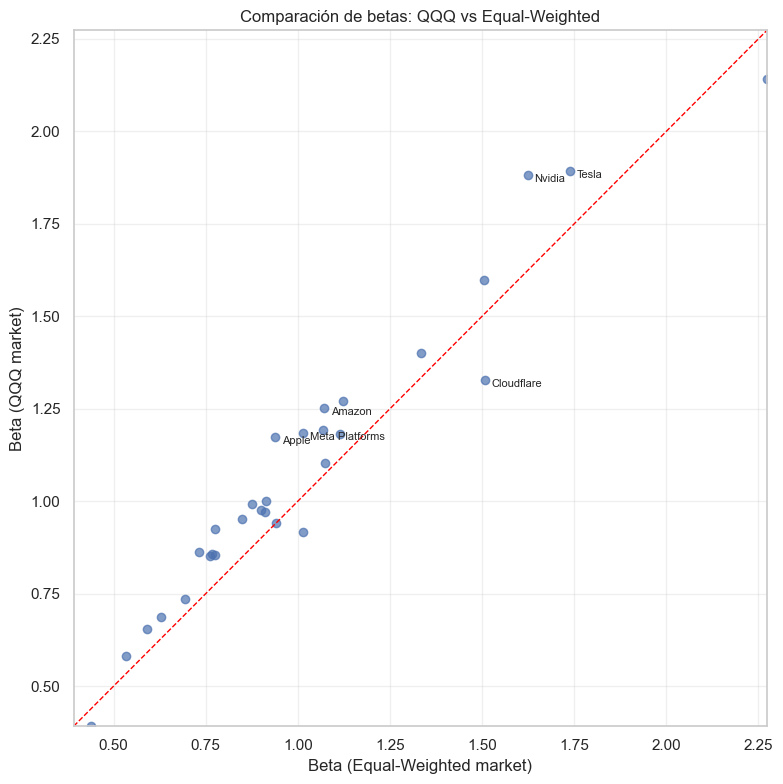

CAPM (QQQ) empresas: 30
CAPM (EQW) empresas: 30
Correlación entre betas (empresas comunes): 0.9700265760819461
Diferencia absoluta promedio entre betas: 0.10605706335058832



### Interpretación CAPM QQQ vs Equal-Weighted

- Número de empresas CAPM QQQ: 30  
- Número de empresas CAPM EQW: 30  
- Correlación entre betas (empresas comunes): 0.970  
- Diferencia absoluta promedio entre betas: 0.106  

**Interpretación:**  
Las betas estimadas usando QQQ y el mercado igual-ponderado son altamente correlacionadas. 
Las diferencias reflejan sensibilidad al benchmark elegido: empresas tech más grandes están 
mejor representadas en QQQ. Este análisis es útil para inversores que usan CAPM para 
evaluar riesgo sistemático en el sector tecnológico.


In [12]:
"""
CAPM (opcional): estimación de betas usando dos benchmarks (QQQ vs equal-weighted)
y comparación entre ambos.

Flujo:
1. Definir regla práctica para rezagos Newey-West.
2. Función que estima CAPM por empresa con OLS + errores robustos (HC1 y HAC).
3. Descargar QQQ, construir mercado equal-weighted y calcular retornos mensuales.
4. Estimar CAPM por empresa para ambos benchmarks y comparar betas.
5. Guardar resultados, trazar scatter de sensibilidad y producir resumen interpretativo.
"""

# Helper: regla práctica para seleccionar rezagos en Newey-West (HAC)
def _newey_west_lags(n_obs):
    return int(np.floor(4 * (n_obs / 100.0) ** (2.0 / 9.0))) if n_obs > 0 else 0


# Función que estima CAPM para una empresa dada usando OLS y errores robustos
def estimate_capm_for_market(company, panel_df, market_returns, market_col='MarketReturn', min_obs=12):
    df_i = panel_df[panel_df['Company'] == company].copy()
    if df_i.empty:
        return None

    # Alineamiento temporal: convertir a fin de mes y hacer merge con los retornos de mercado
    df_i['Date'] = pd.to_datetime(df_i['Date'])
    df_i['MonthEnd'] = df_i['Date'].dt.to_period('M').dt.to_timestamp('M')

    df = (
        df_i.merge(market_returns, left_on='MonthEnd', right_index=True, how='inner')
            .dropna(subset=['Return', market_col])
    )

    n = len(df)
    if n < min_obs:
        return None

    X = sm.add_constant(df[market_col])
    y = df['Return']

    # Estimación OLS y errores robustos
    ols_res = sm.OLS(y, X).fit()
    hc1_res = ols_res.get_robustcov_results(cov_type='HC1')

    maxlags = max(1, _newey_west_lags(n))
    try:
        hac_res = ols_res.get_robustcov_results(cov_type='HAC', maxlags=maxlags)
    except Exception:
        # Fallback conservador si HAC con maxlags falla
        hac_res = ols_res.get_robustcov_results(cov_type='HAC', maxlags=1)

    # Diagnósticos clásicos
    resid = ols_res.resid
    dw = durbin_watson(resid)
    bp_stat, bp_p, _, _ = het_breuschpagan(resid, ols_res.model.exog)

    # Localizar índice del regresor de mercado en el resultado (por si cambia el orden)
    try:
        idx = ols_res.model.exog_names.index(market_col)
    except ValueError:
        idx = 1  # primera columna tras la constante

    out = {
        'Company': company,
        'n_obs': int(n),
        'alpha_ols': float(ols_res.params['const']),
        'beta_ols': float(ols_res.params[market_col]),
        'se_beta_hc1': float(hc1_res.bse[idx]) if hasattr(hc1_res.bse, "__getitem__") else np.nan,
        'p_beta_hc1': float(hc1_res.pvalues[idx]) if hasattr(hc1_res.pvalues, "__getitem__") else np.nan,
        'se_beta_hac': float(hac_res.bse[idx]) if hasattr(hac_res.bse, "__getitem__") else np.nan,
        'p_beta_hac': float(hac_res.pvalues[idx]) if hasattr(hac_res.pvalues, "__getitem__") else np.nan,
        'R2': float(ols_res.rsquared),
        'DW': float(dw),
        'bp_stat': float(bp_stat),
        'bp_p': float(bp_p),
        'maxlags_hac': int(maxlags)
    }
    return out


# Preparar rango de fechas a partir del panel
panel_df['Date'] = pd.to_datetime(panel_df['Date'])
start = panel_df['Date'].min().strftime('%Y-%m-%d')
end = panel_df['Date'].max().strftime('%Y-%m-%d')

# 1) Descargar QQQ y calcular retornos logarítmicos mensuales
qqq = yf.download("QQQ", start=start, end=end, auto_adjust=True, progress=False)
if qqq.empty:
    raise RuntimeError("No se pudieron descargar datos de QQQ. Revisa la conexión o las fechas.")

price = qqq['Close'] if 'Close' in qqq.columns else qqq.iloc[:, 0]
price.index = pd.to_datetime(price.index)
monthly_price = price.resample('M').last().dropna()
market_ret_qqq = np.log(monthly_price / monthly_price.shift(1)).dropna()

# Asegurar que market_ret_qqq sea una Serie con índice MonthEnd
if isinstance(market_ret_qqq, pd.DataFrame):
    market_ret_qqq = market_ret_qqq.iloc[:, 0]
elif isinstance(market_ret_qqq, np.ndarray):
    market_ret_qqq = pd.Series(market_ret_qqq, index=monthly_price.index)

market_returns_qqq = pd.DataFrame({'MarketReturn_QQQ': market_ret_qqq})
market_returns_qqq['MonthEnd'] = market_returns_qqq.index.to_period('M').to_timestamp('M')
market_returns_qqq = market_returns_qqq.set_index('MonthEnd')[['MarketReturn_QQQ']]

# 2) Construir mercado equal-weighted a nivel mensual
panel_df['MonthEnd'] = panel_df['Date'].dt.to_period('M').dt.to_timestamp('M')
equal_w = panel_df.groupby('MonthEnd')['Return'].mean().dropna().to_frame(name='MarketReturn_EQW')

# 3) Ejecutar CAPM para ambos benchmarks
companies = sorted(panel_df['Company'].unique())
capm_results_qqq = []
capm_results_eqw = []

for comp in companies:
    res_q = estimate_capm_for_market(comp, panel_df, market_returns_qqq, market_col='MarketReturn_QQQ', min_obs=12)
    if res_q is not None:
        capm_results_qqq.append(res_q)
    res_e = estimate_capm_for_market(comp, panel_df, equal_w, market_col='MarketReturn_EQW', min_obs=12)
    if res_e is not None:
        capm_results_eqw.append(res_e)

# 4) Construir DataFrames y comparar betas
capm_df_qqq = pd.DataFrame(capm_results_qqq).rename(columns={
    'beta_ols': 'beta_qqq',
    'se_beta_hc1': 'se_beta_hc1_qqq',
    'p_beta_hc1': 'p_beta_hc1_qqq',
    'se_beta_hac': 'se_beta_hac_qqq',
    'p_beta_hac': 'p_beta_hac_qqq'
})
capm_df_eqw = pd.DataFrame(capm_results_eqw).rename(columns={
    'beta_ols': 'beta_eqw',
    'se_beta_hc1': 'se_beta_hc1_eqw',
    'p_beta_hc1': 'p_beta_hc1_eqw',
    'se_beta_hac': 'se_beta_hac_eqw',
    'p_beta_hac': 'p_beta_hac_eqw'
})

capm_compare = pd.merge(
    capm_df_qqq[['Company', 'beta_qqq', 'se_beta_hc1_qqq', 'se_beta_hac_qqq', 'p_beta_hc1_qqq', 'p_beta_hac_qqq', 'n_obs']],
    capm_df_eqw[['Company', 'beta_eqw', 'se_beta_hc1_eqw', 'se_beta_hac_eqw', 'p_beta_hc1_eqw', 'p_beta_hac_eqw', 'n_obs']],
    on='Company',
    how='outer'
)

capm_compare['beta_diff'] = capm_compare['beta_qqq'] - capm_compare['beta_eqw']
capm_compare['abs_beta_diff'] = capm_compare['beta_diff'].abs()

# 5) Estadísticas resumen y guardado
summary_stats = {
    'n_companies_qqq': len(capm_df_qqq),
    'n_companies_eqw': len(capm_df_eqw),
    'mean_beta_qqq': float(capm_df_qqq['beta_qqq'].mean()) if not capm_df_qqq.empty else np.nan,
    'mean_beta_eqw': float(capm_df_eqw['beta_eqw'].mean()) if not capm_df_eqw.empty else np.nan,
    'corr_betas': float(capm_compare[['beta_qqq', 'beta_eqw']].dropna().corr().iloc[0, 1]) if capm_compare[['beta_qqq', 'beta_eqw']].dropna().shape[0] > 1 else np.nan,
    'mean_abs_diff': float(capm_compare['abs_beta_diff'].mean())
}

os.makedirs(PROCESSED_DIR, exist_ok=True)
capm_df_qqq.to_csv(os.path.join(PROCESSED_DIR, 'capm_by_company_qqq.csv'), index=False)
capm_df_eqw.to_csv(os.path.join(PROCESSED_DIR, 'capm_by_company_eqw.csv'), index=False)
capm_compare.to_csv(os.path.join(PROCESSED_DIR, 'capm_compare_qqq_eqw.csv'), index=False)

with open(os.path.join(PROCESSED_DIR, 'capm_compare_summary.json'), 'w') as f:
    json.dump(summary_stats, f, indent=4)

# 6) Scatter plot: beta_eqw vs beta_qqq (anotar las mayores diferencias)
plt.figure(figsize=(8, 8))
plt.scatter(capm_compare['beta_eqw'], capm_compare['beta_qqq'], alpha=0.7)
lims = [
    np.nanmin([capm_compare['beta_eqw'].min(), capm_compare['beta_qqq'].min()]),
    np.nanmax([capm_compare['beta_eqw'].max(), capm_compare['beta_qqq'].max()])
]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Beta (Equal-Weighted market)')
plt.ylabel('Beta (QQQ market)')
plt.title('Comparación de betas: QQQ vs Equal-Weighted')

top6 = capm_compare.sort_values('abs_beta_diff', ascending=False).head(6)
for _, row in top6.iterrows():
    if pd.notna(row['beta_eqw']) and pd.notna(row['beta_qqq']):
        plt.annotate(row['Company'], (row['beta_eqw'], row['beta_qqq']),
                     xytext=(5, -5), textcoords='offset points', fontsize=8)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR, 'beta_qqq_vs_eqw_scatter.png'), dpi=300)
plt.show()

# 7) Resumen numérico e interpretación
print("CAPM (QQQ) empresas:", len(capm_df_qqq))
print("CAPM (EQW) empresas:", len(capm_df_eqw))
print("Correlación entre betas (empresas comunes):", summary_stats['corr_betas'])
print("Diferencia absoluta promedio entre betas:", summary_stats['mean_abs_diff'])

capm_compare.head(15)

markdown_text = f"""
### Interpretación CAPM QQQ vs Equal-Weighted

- Número de empresas CAPM QQQ: {summary_stats['n_companies_qqq']}  
- Número de empresas CAPM EQW: {summary_stats['n_companies_eqw']}  
- Correlación entre betas (empresas comunes): {summary_stats['corr_betas']:.3f}  
- Diferencia absoluta promedio entre betas: {summary_stats['mean_abs_diff']:.3f}  

**Interpretación:**  
Las betas estimadas usando QQQ y el mercado igual-ponderado son altamente correlacionadas. 
Las diferencias reflejan sensibilidad al benchmark elegido: empresas tech más grandes están 
mejor representadas en QQQ. Este análisis es útil para inversores que usan CAPM para 
evaluar riesgo sistemático en el sector tecnológico.
"""
display(Markdown(markdown_text))


In [13]:
# =========================
# GUARDAR RESULTADOS FINALES 
# =========================

# -----------------------------
# Crear carpeta de destino
# -----------------------------
# Se asegura que la carpeta "inference" dentro de PROCESSED_DIR exista
# Si no existe, se crea incluyendo cualquier carpeta padre necesaria
processed_path = Path(PROCESSED_DIR) / "inference"
processed_path.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Comprobación de variables necesarias
# -----------------------------
# Verifica que las variables críticas existan en el entorno antes de guardar
required_vars = ["ci_df", "tt_df", "capm_df_qqq", "out_df"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Faltan variables necesarias: {missing}")

# -----------------------------
# Guardar resultados principales en CSV
# -----------------------------
# Guardar intervalos de confianza por empresa
ci_df.to_csv(processed_path / "ci_mean_by_company.csv", index=False)
# Guardar resultados de t-tests de una muestra por empresa
tt_df.to_csv(processed_path / "one_sample_ttests_by_company.csv", index=False)

# Guardar CAPM principal (QQQ) y opcionales
capm_df_qqq.to_csv(processed_path / "capm_by_company.csv", index=False)
if 'capm_df_eqw' in globals():
    capm_df_eqw.to_csv(processed_path / "capm_by_company_eqw.csv", index=False)
if 'capm_compare' in globals():
    capm_compare.to_csv(processed_path / "capm_compare_qqq_eqw.csv", index=False)

# -----------------------------
# Guardar resumen JSON: comparación de grupos Beta
# -----------------------------
# Extrae métricas clave del DataFrame out_df para guardarlas en un archivo JSON
if not out_df.empty:
    row = out_df.iloc[0]

    group_summary = {
        "groupA_n": int(row.get("n_groupA", 0)),
        "groupA_mean": float(row.get("mean_A", np.nan)),
        "groupA_sd": float(row.get("sd_A", np.nan)),

        "groupB_n": int(row.get("n_groupB", 0)),
        "groupB_mean": float(row.get("mean_B", np.nan)),
        "groupB_sd": float(row.get("sd_B", np.nan)),

        "welch_t": float(row.get("welch_t", np.nan)),
        "welch_p": float(row.get("welch_p", np.nan)),
        "welch_CI": [
            float(row.get("welch_CI_low", np.nan)),
            float(row.get("welch_CI_high", np.nan))
        ],

        "mw_p": float(row.get("mw_p", np.nan)),
        "perm_p": float(row.get("perm_p", np.nan)),
        "bootstrap_diff_CI": [
            float(row.get("boot_diff_CI_low", np.nan)),
            float(row.get("boot_diff_CI_high", np.nan))
        ],
        "bootstrap_p": float(row.get("boot_diff_p", np.nan)),

        "hedges_g": float(row.get("hedges_g", np.nan))
    }

    # Guardar archivo JSON con formato legible
    with open(processed_path / "group_beta_comparison_summary.json", "w") as f:
        json.dump(group_summary, f, indent=4)
else:
    print("⚠️ out_df está vacío, no se guardó resumen JSON")

# -----------------------------
# Guardar resumen JSON CAPM
# -----------------------------
# Si existe la comparación de CAPM, extrae métricas resumidas y guarda JSON
summary_capm_json = {}
if 'capm_compare' in globals() and not capm_compare.empty:
    summary_capm_json = {
        'n_companies_qqq': int(capm_df_qqq.shape[0]),
        'n_companies_eqw': int(capm_df_eqw.shape[0]) if 'capm_df_eqw' in globals() else np.nan,
        'mean_beta_qqq': float(capm_df_qqq['beta_qqq'].mean()),
        'mean_beta_eqw': float(capm_df_eqw['beta_eqw'].mean()) if 'capm_df_eqw' in globals() else np.nan,
        'corr_betas': float(capm_compare[['beta_qqq','beta_eqw']].dropna().corr().iloc[0,1]),
        'mean_abs_diff': float(capm_compare['abs_beta_diff'].mean())
    }

    with open(processed_path / "capm_compare_summary.json", "w") as f:
        json.dump(summary_capm_json, f, indent=4)

# -----------------------------
# Mensaje final de confirmación
# -----------------------------
print("✅ Todos los resultados finales fueron guardados correctamente en /data/processed")


✅ Todos los resultados finales fueron guardados correctamente en /data/processed
